In [1]:
import arkouda as ak
import arachne as ar
import pandas as pd
import scipy as sp
import scipy.io
import networkx as nx
import matplotlib.pyplot as plt

    _         _                   _       
   / \   _ __| | _____  _   _  __| | __ _ 
  / _ \ | '__| |/ / _ \| | | |/ _` |/ _` |
 / ___ \| |  |   < (_) | |_| | (_| | (_| |
/_/   \_\_|  |_|\_\___/ \__,_|\__,_|\__,_|
                                          

Client Version: v2023.02.08


In [2]:
ak.connect("node21", 5554)

connected to arkouda server tcp://*:5554


In [3]:
cfg = ak.get_config()
print(cfg)

{'arkoudaVersion': 'v2023.02.08', 'chplVersion': '1.29.0', 'ZMQVersion': '4.3.4', 'HDF5Version': '1.12.2', 'serverHostname': 'node21', 'ServerPort': 5554, 'numLocales': 4, 'numPUs': 20, 'maxTaskPar': 20, 'physicalMemory': 540958285824, 'distributionType': 'BlockDom(1,int(64),false,unmanaged DefaultDist)', 'LocaleConfigs': [{'id': 0, 'name': 'node21', 'numPUs': 20, 'maxTaskPar': 20, 'physicalMemory': 540958285824}, {'id': 1, 'name': 'node22', 'numPUs': 20, 'maxTaskPar': 20, 'physicalMemory': 540958294016}, {'id': 2, 'name': 'node23', 'numPUs': 20, 'maxTaskPar': 20, 'physicalMemory': 540958294016}, {'id': 3, 'name': 'node24', 'numPUs': 20, 'maxTaskPar': 20, 'physicalMemory': 540958294016}], 'authenticate': False, 'logLevel': 'INFO', 'logChannel': 'CONSOLE', 'regexMaxCaptures': 20, 'byteorder': 'little', 'autoShutdown': False, 'serverInfoNoSplash': False}


# Introduction to Graph Analytics In Arachne

When it comes to processing graphs in an interactive supercomputing environment, we may have many algorithms available to us and a difficult time picking which one would be the best option for a particular problem at hand. In this section, we will give a rundown on each implemented algorithm and how it can be utilized for graph analysis.

For anyone new to graph analytics, we will make it as welcoming as possible. First, let us define a graph. Let $G = (V,E)$ where $V$ is a set of vertices (nodes used interchangeably) and $E$ is a set of edges with $n = |V|$ vertices and $m = |E|$ edges. A graph can be either directed or undirected, or have weighted vertices or edges or not. Some graph algorithms work independently of vertex or edge weights.

## Reading in a Graph

Currently, Arachne provides two functions to read in a graph and build the graph data structure. These two functions allow to read a graph in three different formats: as an edge list, as a MatrixMarket file, and from preexisting arkouda arrays. 

An edge list is just as it sounds, a list of the edges that exist in a graph. If the graph has m=4 edges, then the file has m=>4 lines. Comments are allowed but their starting character must be specified as a paramater in the reading method. Each line must be delimited by a newline character. An example follows.
```
1     2
2     3
3     4
```

The MatrixMarket format stems from storing dense and sparse matrices. Since graphs can be represented as adjacency matrices, they can also be outputted to a MatrixMarket (.mtx) file. The specification for MatrixMarket files can be found [here](https://www.markdownguide.org/basic-syntax/). An example follows.
```
%%MatrixMarket matrix coordinate real general
%=================================================================================
%
% This ASCII file represents a sparse MxN matrix with L 
% nonzeros in the following Matrix Market format:
%
% +----------------------------------------------+
% |%%MatrixMarket matrix coordinate real general | <--- header line
% |%                                             | <--+
% |% comments                                    |    |-- 0 or more comment lines
% |%                                             | <--+         
% |    M  N  L                                   | <--- rows, columns, entries
% |    I1  J1  A(I1, J1)                         | <--+
% |    I2  J2  A(I2, J2)                         |    |
% |    I3  J3  A(I3, J3)                         |    |-- L lines
% |        . . .                                 |    |
% |    IL JL  A(IL, JL)                          | <--+
% +----------------------------------------------+   
%
% Indices are 1-based, i.e. A(1,1) is the first element.
%
%=================================================================================
  5  5  8
    1     1   1.000e+00
    2     2   1.050e+01
    3     3   1.500e-02
    1     4   6.000e+00
    4     2   2.505e+02
    4     4  -2.800e+02
    4     5   3.332e+01
    5     5   1.200e+01
```

Lastly, since Arachne is an extension to Arkouda there will be cases where a large dataset has already been read in that may contain some form of `src->dst` relationships contained. Therefore, we provide a method, just as in NetworkX called `G.add_edges_from(src, dst, wgt)` that adds to a Graph or DiGraph object the edges contained in the arrays `src`, `dst`, and `wgt`. The last array, wgt, is optional. 

Below we read in the graph saved in the MatrixMarket format. Since for graphs, nonzeros are akin to edges, we maintain the ability to read in a MatrixMarket file in the read_edgelist() method.

In [4]:
filepath = "/rhome/oaa9/Research/arkouda_extension/testing_files/data/graphs_simple/karate.mtx"
G = ar.read_edgelist(filepath, filetype="mtx")

We can extract the edges out from our graph as well as our vertices as pdarrays. These could be used for any further analyses if needed.

In [5]:
edge_src, edge_dst = G.edges()
edge_list = []
for i in range(G.size()):
    edge_list.append((edge_src[i], edge_dst[i]))


nodes = G.nodes()

print(edge_list)
print()
print(nodes)

[(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1), (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4), (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2), (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1), (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23), (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8), (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8), (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23), (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13), (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22), (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30), (33, 31), (33, 32)]

[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]


Let us also read the graph in with NetworkX so we can ensure our data structure is building the same exact graph.

In [6]:
fh = open(filepath, "rb")
H = nx.from_scipy_sparse_array(sp.io.mmread(fh))
print(len(G), len(H))
print(G.size(), H.size())

34 34
78 78


We are also able to display our graph with NetworkX methods by exporting our edgelist and building a graph from the edges stored by Arachne. **Note: Visualization is resource-intensive, so you can really only do it for small graphs. However, we perform these steps to show how Arachne can complement NetworkX and how graphs can be exchanged between them.**

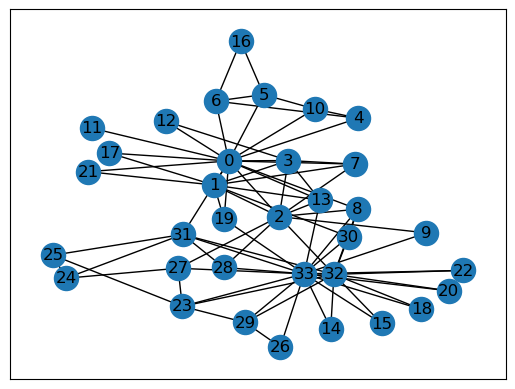

In [7]:
nx_display = nx.Graph()
nx_display.add_edges_from(edge_list)

pos = nx.kamada_kawai_layout(nx_display)
nx.draw_networkx(nx_display, pos, with_labels=True)
plt.show()

Below we also see how we can extract a degree view for a graph to see the dispersion of degrees amongst the vertices.

In [8]:
degrees = G.degree()
print(degrees)

[16 9 10 6 3 4 4 4 5 2 3 1 2 5 2 2 2 2 2 3 2 2 2 5 3 3 2 4 3 4 4 6 12 17]


Using Arkouda arrays we can also extract the node with maximum degree.

In [9]:
print(f"Node {ak.argmax(degrees)} has maximum degree of {ak.max(degrees)}")

Node 33 has maximum degree of 17


## Breadth-First Search

Given a graph $G$ (as defined above) and a source vertex $s$, breadth-first search (BFS) traverses the graph in a level-centric manner. It can return the tree inherently generated during BFS, the vertices found at each layer, or an ordering of nodes as predecessors or successors. For our implementation we opted to mimic NetworkX's `bfs_layers` function that returns the nodes and the layer they belong to.

Our BFS method, written in Chapel, expands the next frontier in parallel on each locale, if it is run on a distributed cluster. Each locale iterates over the frontier, and if there are any local edges, it inspects the neighbors, and if not yet visited, updates the `depth` (layer) pdarray. The final `depth` array is returned which can be used to provide a different view of a graph.

In [10]:
d = ar.bfs_layers(G, 0)
print(d)

[0 1 1 1 1 1 1 1 1 2 1 1 1 1 3 3 2 1 3 1 3 1 3 3 2 2 3 2 2 3 2 1 2 2]


We may also extract a histogram of the sizes of each level computed by BFS. This can be a useful manner in seeing how how big each group of nodes at a particular hop is.

In [11]:
d_histogram = ak.histogram(d, bins=ak.max(d)+1)
print(d_histogram[1])

[1 16 9 8]


From the above we can see that at level 0 we obviously only have one vertex. Then, we can see that at level 1 we have 16, level 2 we have 9, and level 3 we have 8. The maximum level is 3. What happens if we change the source vertex? Let's see the results of bfs_layers for each vertex.

In [12]:
for i in range(len(G)):
    d = ar.bfs_layers(G, i)
    d_histogram = ak.histogram(d, bins=ak.max(d)+1)
    print(f"node {i}: {d_histogram[1]}")

node 0: [1 16 9 8]
node 1: [1 9 13 11]
node 2: [1 10 20 3]
node 3: [1 6 16 11]
node 4: [1 3 14 8 8]
node 5: [1 4 13 8 8]
node 6: [1 4 13 8 8]
node 7: [1 4 17 11 1]
node 8: [1 5 25 3]
node 9: [1 2 20 10 1]
node 10: [1 3 14 8 8]
node 11: [1 1 15 9 8]
node 12: [1 2 14 9 8]
node 13: [1 5 25 3]
node 14: [1 2 16 6 8 1]
node 15: [1 2 16 6 8 1]
node 16: [1 2 3 12 8 8]
node 17: [1 2 15 8 8]
node 18: [1 2 16 6 8 1]
node 19: [1 3 27 3]
node 20: [1 2 16 6 8 1]
node 21: [1 2 15 8 8]
node 22: [1 2 16 6 8 1]
node 23: [1 5 15 4 8 1]
node 24: [1 3 6 23 1]
node 25: [1 3 6 23 1]
node 26: [1 2 15 6 9 1]
node 27: [1 4 20 8 1]
node 28: [1 3 21 8 1]
node 29: [1 4 15 5 8 1]
node 30: [1 4 20 8 1]
node 31: [1 6 26 1]
node 32: [1 12 12 8 1]
node 33: [1 17 6 9 1]


From the output above we notice some main things:
1. Starting BFS from different sources arise to different number of layers for the output of each node.
2. Some nodes have the same number of vertices at each layer. 
3. Node 19 provides the largest layer for any of the nodes. 

Let's color the nodes for node 19 and show the output.

[1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 0 2 2 2 2 3 3 2 2 2 2 2 2 2 1]
[1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 21, 25, 23, 24, 27, 28, 29, 26, 30, 31, 32, 14, 15, 18, 20, 22, 33]


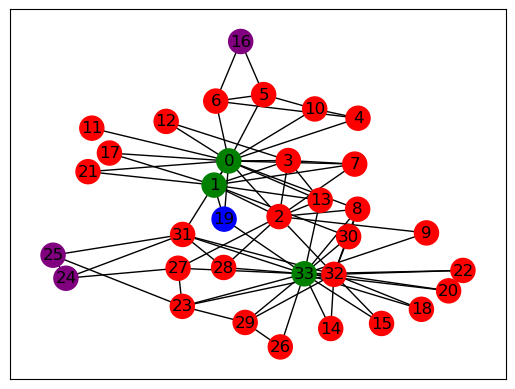

degrees = [16 9 10 6 3 4 4 4 5 2 3 1 2 5 2 2 2 2 2 3 2 2 2 5 3 3 2 4 3 4 4 6 12 17]


In [23]:
d = ar.bfs_layers(G, 19)
color_dict = {0:"blue", 1:"green", 2:"red", 3:"purple"}
print(d)

color_map = []
nodes = nx_display.nodes()
for u in nodes:
    color_map.append(color_dict[d[u]])
    
print(nx_display.nodes)

pos = nx.kamada_kawai_layout(nx_display)
nx.draw_networkx(nx_display, pos, with_labels=True, node_color=color_map)
plt.show()

print(f"degrees = {degrees}")

In the returned image we can see the first frontier are the green vertices $<0, 1, 33>$. If we look at the degree view of the graph we notice that 0, 1, and 33 are in the top 4 of vertices with most degree, which now makes sense why vertex 19 had the largest expanded frontier. 

## Connected Components

Given a graph G, (as defined above) if there is a path from a vertex $u$ to every other vertex $v$ then the graph is said to be connected. If there is not a path, then the graph is said to be disconnected and composed of multiple connected components. There may be a large number of connected components of varying sizes in a graph.

One of the most ancient manners of calculating connected components involve running BFS until every vertex has been visited, at every iteration looking for the node whose value `-1` and start BFS from it. These steps are repeated until all the vertices have been labeled. The other is using union-find to build a tree induced by each connected component. For our method we use a lbel propagation technique that sends the minimum vertex label to all the other vertices in a connected component.

To run our connected components, you just have to call the `connected_components()` method. We modified the karate graph by adding some connected components into it, let's now analyze the returned data.

In [24]:
filepath = "/rhome/oaa9/Research/arkouda_extension/testing_files/data/graphs_simple/karate_mod.mtx"
Gmod = ar.read_edgelist(filepath, filetype="mtx")

cc = ar.connected_components(Gmod)
print(cc)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 34 34 34 34 34 34 34 34 34]


We can use Arkouda methods to get the size of each component in our file. This will let us know which vertices will be included in the induced subgraph of the largest component.

In [25]:
g = ak.GroupBy(cc)
keys, count = g.count()
label_of_largest_component = ak.argmax(count)
label_of_smallest_component = ak.argmin(count)
print(f"The largest component is labeled: {keys[label_of_largest_component]}")
print(f"The smallest component is labeled: {keys[label_of_smallest_component]}")

The largest component is labeled: 0
The smallest component is labeled: 34


We can generate a subgraph of our smallest component by looping over our edge arrays and checking to see if they are equal to the label of our smallest component.

In [26]:
Gmod_edges = Gmod.edges()
new_src = []
new_dst = []
for i in range(Gmod.size()):
    if (cc[Gmod_edges[0][i]] == 34):
        new_src.append(Gmod_edges[0][i])
        new_dst.append(Gmod_edges[1][i])

Now, we generate our new graph and inspect the number of edges and vertices returned for it. It will be interesting to see exactly how much smaller our induced subgraph is!

In [27]:
new_Gmod = ar.Graph()
new_src = ak.array(new_src)
new_dst = ak.array(new_dst)

new_Gmod.add_edges_from(new_src, new_dst)

print(f"New number of vertices: {len(new_Gmod)}")
print(f"New number of edges: {new_Gmod.size()}")
print(f"There are {Gmod.size() - new_Gmod.size()} fewer edges and {len(Gmod) - len(new_Gmod)} fewer vertices.")

New number of vertices: 9
New number of edges: 9
There are 78 fewer edges and 34 fewer vertices.


We can also view our different components by visualizing the graph using NetworkX, similar to what we did for BFS!

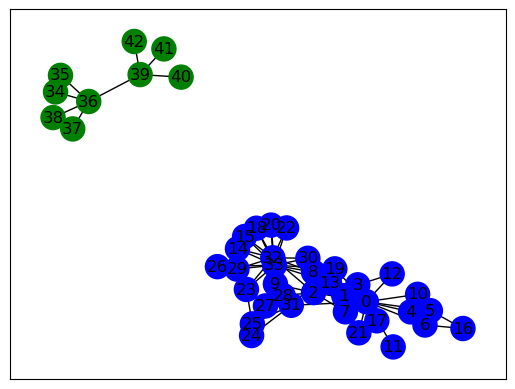

In [28]:
nx_Gmod = nx.Graph()
nx_Gmod.add_edges_from(zip(Gmod_edges[0].to_ndarray(), Gmod_edges[1].to_ndarray()))

color_dict = {0:"blue", 34:"green"}

color_map = []
for i in range(len(Gmod)):
    color_map.append(color_dict[cc[i]])

pos = nx.spring_layout(nx_Gmod, seed=200)
nx.draw_networkx(nx_Gmod, pos, with_labels=True, node_color=color_map)
plt.show()

## Triangle Counting

One of the most basic community structures that can be found in graphs are triangles. Triangles are 3-cliques in an undirected graph which means three nodes are strongly connected to each other. Triangle counting can be used to detect how cohesive communities are, the more triangles there are, the better connected a community is. It can also be used to drive other graph analytical algorithms such as centrality measures (triangle centrality) and substructure detection (k-truss analytics).

Our triangle counting method involves inspecting every edge in a graph and the adjacency lists of both endpoints to find the intersection point. Most algorithms perform list intersection, for our case we perform a binary search of every vertex in the smaller adjacency list into the bigger one. This allows us to efficiently find triangles with less work.

The example below shows how we can call our triangle method. Please note the second parameter is for finding the number of triangles adjacent to the vertices in that array. To find all the triangles, the default has to be set to a `pdarray` with only `-1` in it.

In [29]:
G_tri = ar.triangles(G, ak.array([-1]))
print(G_tri)

[45]


## Truss Analytics

Given a graph $G$ (as defined above), the $k$-truss of a graph is one where every edge is a part of least $k-2$ triangles. This creates a subhesive subgraph where only the edges that meet these requirement are kept. It involves recalculating the number of triangles multiple times, which we avoid by tracking the support of each edge at every iteration of the algorithm. We provide novel algorithmic implementations for three truss analytical algorithms:
1. $k$-truss
2. max-truss
3. truss decomposition

Below we run `k_truss` and display the edges that belong to at least 2 triangles. We could build an induced subgraph from these edges in the same manner as we showed above.

In [30]:
kt = ar.k_truss(G, 4)
print(kt)

[-1 -1 -1 -1 -1 -1 3 3 3 3 3 -1 -1 -1 -1 3 3 3 3 3 3 3 3 3 -1 -1 -1 -1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 -1 3 3 -1 3 3 3 3 3 -1 3 3 3 3 3 -1 -1 -1 3 -1 3 3 3 3 3 3 3 3 -1 3 3 3 -1 -1 3 -1]


Here, we see that the maximum truss of this graph is 5. This means that the $k$-truss is no longer defined for any value of $k$ larger than 5.

In [31]:
mt = ar.k_truss(G, -1)
print(mt)

[5 0]


Lastly, the truss decomposition shows the trussness of every edge. This means that the largest value of k for every edge is the one presented in the edge index. 

In [32]:
td = ar.k_truss(G, -2)
print(td)

[5 5 5 5 5 5 3 3 3 3 3 5 5 5 5 3 3 2 3 3 3 2 3 3 5 5 5 5 3 3 3 3 3 3 3 3 2 3 2 3 2 2 4 3 2 4 2 3 3 3 3 4 3 3 3 3 3 4 4 4 3 4 2 2 3 3 3 2 3 3 4 3 3 3 4 4 3 4]


Using similar coloring steps as above, we can actually color the edges of the graph. The steps for that are below.

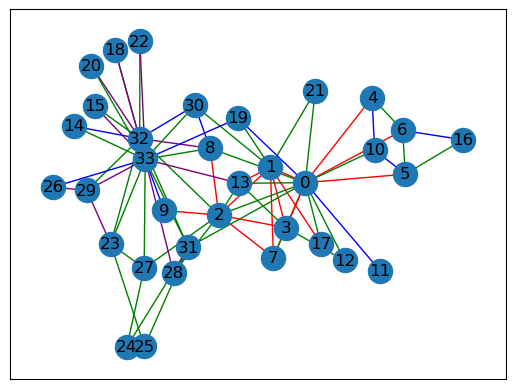

In [33]:
color_dict = {5:"red", 3:"green", 2:"blue", 4:"purple"}
edge_color = []

for i in range(G.size()):
    edge_color.append(color_dict[td[i]])
    
pos = nx.spring_layout(nx_display, seed=200)
nx.draw_networkx(nx_display, pos, with_labels=True, edge_color=edge_color)
plt.show()

## Triangle Centrality

Lastly, we present the triangle centrality for graphs. Basically, it is a centrality measure to decide how important a vertex is based off how many triangles surround a particular vertex. It is calculated based off the following formula as seen in the paper titled "Triangle Centrality" by Paul Burkhardt.

$$TC(v) = \frac{\frac{1}{3} \sum_{u \in N_{\Delta}^{+}(v)}{\Delta(u)} + \sum_{w \in (N(v) \backslash N_{\Delta}(v))} {\Delta (w)}}{\Delta(G)}$$

Where $N(v)$ is the neighborhood set of a vertex $v$, $N_{\Delta}(v)$ is the set of neighbors that are in triangles with $v$, and $N_{\Delta}^{+}$ is the closed set that includes $v$. There is not an equivalent metric of this form available in NetworkX.

In [34]:
tce = ar.triangle_centrality(G)
print(tce)

[6.296296e-01 5.555556e-01 6.148148e-01 4.740741e-01 1.851852e-01 2.000000e-01 2.000000e-01 4.222222e-01 4.814815e-01 1.925926e-01 1.851852e-01 1.333333e-01 2.148148e-01 7.555556e-01 2.148148e-01 2.148148e-01 5.185185e-02 2.296296e-01 2.148148e-01 3.407407e-01 2.148148e-01 2.296296e-01 2.148148e-01 2.814815e-01 4.444444e-02 6.666667e-02 1.481481e-01 2.370370e-01 2.222222e-01 2.740741e-01 5.333333e-01 3.851852e-01 4.666667e-01 5.481481e-01]


In [35]:
print(f"One of the most important vertices in the graph is: {ak.argmax(tce)}")

One of the most important vertices in the graph is: 13


In [26]:
G = ar.read_edgelist("/rhome/oaa9/Research/arkouda_extension/testing_files/data/graphs_simple/simp_triangles.txt")
print(ar.triangle_centrality(G))

[6.000000e-01 6.000000e-01 4.666667e-01 7.333333e-01 7.333333e-01 4.666667e-01 4.000000e-01 4.666667e-01 4.000000e-01]
